# About
This notebook was used to produce Figure 3.

# Prereqs

In [1]:
import collections
import csv
import gzip
import pathlib
import sys
import time

In [2]:
from matplotlib import pyplot

In [3]:
%matplotlib inline

In [4]:
MAIN_DIR = pathlib.Path('/nfs/brubeck.bx.psu.edu/scratch5/nick/overlaps/auto/ecoli')
CSV_PATH = MAIN_DIR/'sra.runinfo3.csv.gz'
COLORS = collections.OrderedDict((('A','#3ab53a'), ('T','#d24343'), ('C','#3491d1'), ('G','#f68b2b')))
BASES = tuple(COLORS.keys())

## Reading metadata

In [5]:
def read_runinfo(csv_path):
  start = time.perf_counter()
  int_fields = {'spots', 'spots_with_mates', 'avgLength', 'size_MB', 'InsertSize', 'InsertDev', 'ProjectID', 'TaxID'}
  runs = {}
  header = {}
  empty_lines = 0
  header_lines = 0
  try:
    with gzip.open(csv_path, 'rt') as csv_file:
      for row in csv.reader(csv_file):
        if not header:
          header_lines += 1
          for i, value in enumerate(row):
            header[i] = value
          RunInfo = collections.namedtuple('RunInfo', header.values())
          continue
        if len(row) == 0:
          empty_lines += 1
          continue
        assert len(row) == len(header), (len(row), row)
        header_matches = 0
        value_dict = {}
        for i, raw_value in enumerate(row):
          if raw_value == header[i]:
            header_matches += 1
          else:
            if header[i] in int_fields:
              try:
                value = int(raw_value)
              except ValueError:
                if header[i] == 'InsertDev':
                  value = float(raw_value)
                else:
                  print(f'{header[i]}: {raw_value!r}', file=sys.stderr)
            else:
              value = raw_value
          value_dict[header[i]] = value
        if header_matches > 5:
          header_lines += 1
          continue
        runs[value_dict['Run']] = RunInfo(**value_dict)
  except EOFError:
    print('Incomplete gzip.', file=sys.stderr)
  elapsed = time.perf_counter() - start
  print(f'{len(runs)} runs in {elapsed:0.1f} seconds (headers: {header_lines}, empty lines: {empty_lines})')
  return runs

## Read in the metadata

In [6]:
RUNS = read_runinfo(CSV_PATH)

186022 runs in 12.0 seconds (headers: 1, empty lines: 0)


In [7]:
def matches_platform(runs, sample, platform):
  run = runs.get(sample)
  if not run:
    return False
  if platform == run.Model:
    return True
  abbrev = ' '.join(run.Model.split()[1:])
  if platform == abbrev:
    return True
  return False

In [8]:
def get_done_samples(done_file='seq-context.tsv', platform=None, runs=None, main_dir=MAIN_DIR):
  if (platform and not runs) or (runs and not platform):
    raise ValueError(f'Must provide both platform and runinfos, or neither.')
  for sample_dir in (main_dir/'runs').iterdir():
    sample = sample_dir.name
    context_path = sample_dir/done_file
    if not context_path.is_file():
      continue
    if (platform and runs) and not matches_platform(runs, sample, platform):
      continue
    yield sample

# Results
## Data reading functions

In [9]:
def load_counts(counts_path):
  counts_by_substitution = collections.defaultdict(lambda: collections.defaultdict(collections.Counter))
  with counts_path.open() as counts_file:
    for line_raw in counts_file:
      fields = line_raw.rstrip('\r\n').split('\t')
      before_base, after_base_str, pos_str, ref_base, count_str = fields
      if after_base_str == 'None':
        after_base = None
      else:
        after_base = after_base_str
      pos = int(pos_str)
      count = int(count_str)
      counts_by_substitution[(before_base, after_base)][pos][ref_base] = count
  return counts_by_substitution

In [10]:
def fold_counts(counts_by_substitution):
  new_counts_by_sub = {}
  for substitution, counts_by_pos in counts_by_substitution.items():
    new_counts_by_pos = new_counts_by_sub.setdefault(substitution, collections.defaultdict(collections.Counter))
    for pos, counts_by_base in counts_by_pos.items():
      abs_pos = abs(pos)
      # Skip 0 and positions where we don't have both upstream and downstream counts.
      if abs_pos == 0 or not (abs_pos in counts_by_pos and -abs_pos in counts_by_pos):
        continue
      for ref_base, count in counts_by_base.items():
        new_counts_by_pos[abs_pos][ref_base] += count
  return new_counts_by_sub

In [11]:
def get_combined_base_counts(samples, folded=False):
  base_counts_list = []
  for sample in samples:
    summary_path = MAIN_DIR/'runs'/sample/'seq-context-summary.tsv'
    if summary_path.is_file():
      counts = load_counts(summary_path)
      if folded:
        base_counts = fold_counts(counts)
      else:
        base_counts = counts
      base_counts_list.append(base_counts)
  return combine_base_counts(base_counts_list)

In [12]:
def combine_base_counts(base_counts_by_sub_list):
  base_counts_by_sub_combined = collections.defaultdict(lambda: collections.defaultdict(collections.Counter))
  for base_counts_by_sub in base_counts_by_sub_list:
    for mutation, counts_by_pos in base_counts_by_sub.items():
      for rel_pos, base_counts in counts_by_pos.items():
        for base, count in base_counts.items():
          base_counts_by_sub_combined[mutation][rel_pos][base] += count
  return base_counts_by_sub_combined

## Read in the data

In [13]:
start = last = time.perf_counter()
count_sets = {}
for platform in 'MiSeq', 'HiSeq 2500', 'HiSeq X Ten', 'MiniSeq', 'NextSeq 500', 'NextSeq 550', 'NovaSeq 6000':
  samples = list(get_done_samples(done_file='seq-context.tsv', platform=platform, runs=RUNS))
  count_sets[platform] = get_combined_base_counts(samples, folded=True)
  now = time.perf_counter()
  elapsed = now - last
  print(f'Finished {len(samples)} runs from {platform} in {round(elapsed)} seconds..')
  last = now
elapsed = now - start
print(f'Total: {round(elapsed)/60:0.1f} minutes')

Finished 299 runs from MiSeq in 13 seconds..
Finished 273 runs from HiSeq 2500 in 10 seconds..
Finished 295 runs from HiSeq X Ten in 11 seconds..
Finished 69 runs from MiniSeq in 7 seconds..
Finished 267 runs from NextSeq 500 in 10 seconds..
Finished 282 runs from NextSeq 550 in 9 seconds..
Finished 346 runs from NovaSeq 6000 in 12 seconds..
Total: 1.2 minutes


## Plotting functions

In [14]:
NUM_SCALE_POSTFIXES = {1:'', 10**3:'\n(thousands)', 10**6:'\n(millions)', 10**9:'\n(billions)'}
TITLE_X_PARAMS = [
  None,
  {'slope':0.512, 'intercept':0},
  {'slope':0.42, 'intercept':-0.12},
  {'slope':0.275, 'intercept':-0.04},
  {'slope':0.2, 'intercept':0.01},
  {'slope':0.16, 'intercept':0.032},
  {'slope':0.133, 'intercept':0.0445},
  {'slope':0.1133, 'intercept':0.0574},
]
def counts_multimultiplot(
    count_sets, scale=1, aspect=1.7, columns=2,
    folded=False, num_scale=1, substitutions=None,
  ):
  if substitutions is None:
    substitutions = []
    counts_by_sub = list(count_sets.values())[0]
    for substitution in counts_by_sub.keys():
      if substitution is not None and substitution[0] in BASES and substitution[1] in BASES:
        substitutions.append(substitution)
  else:
    # Convert from list of strings to tuples, if necessary.
    substitutions = [(before, after) for before, after in substitutions]
  ylabel = 'Base occurrences'+NUM_SCALE_POSTFIXES[num_scale]
  rows = len(substitutions)
  columns = len(count_sets)
  title_x_params = TITLE_X_PARAMS[columns]
  figheight = rows*3
  figwidth = columns*3*aspect
  figure = pyplot.figure(dpi=180*scale, figsize=(figwidth,figheight))
  subplot_num = 0
  for column, (set_name, counts_by_sub) in enumerate(count_sets.items(), 1):
    for row, substitution in enumerate(substitutions, 1):
      try:
        counts_by_pos = counts_by_sub[substitution]
      except KeyError:
        continue
      subplot_num = (row-1) * columns + column
      axes = figure.add_subplot(rows, columns, subplot_num)
      bars = plot_base_counts(axes, counts_by_pos, reverse_x=folded, num_scale=num_scale)
      axes.set_title('{0} → {1}'.format(*substitution))
      if row < rows:
        axes.set_xticks(())
    title_x = column*title_x_params['slope'] + title_x_params['intercept']
    if rows <= 2:
      title_y = 1.12 - 0.06*rows
    else:
      title_y = 0.965 - 0.011*rows
    figure.text(title_x, title_y, set_name, fontsize=18, horizontalalignment='center')
  xlabel_y = 0.009*rows + 0.03
  if columns <= 4:
    ylabel_x = 0.03*columns - 0.03
  else:
    ylabel_x = 0.005*columns + 0.065
  figure.text(ylabel_x, 0.55, ylabel, fontsize=18, horizontalalignment='center', rotation='vertical')
  figure.text(0.5, xlabel_y, 'Position relative to error', fontsize=18, horizontalalignment='center')
  figure.patch.set_facecolor('white')
  pyplot.show()

In [15]:
def plot_base_counts(axes, counts_by_pos, colors=COLORS, reverse_x=False, num_scale=1):
  """`counts_by_pos` should be a mapping of:
    context coord -> [context base -> count]
  e.g.
    counts_by_pos[-7]['A'] == 966400"""
  bases = tuple(colors.keys())
  counts: Dict[str,List[int]] = {}
  positions: List[int] = []
  for base in bases:
    counts[base] = []
    for i, (pos, pos_counts) in enumerate(counts_by_pos.items()):
      count = pos_counts[base] / num_scale
      if base == bases[0]:
        positions.append(pos)
      counts[base].append(count)
  plots = {}
  tops = [0] * len(positions)
  for base in bases:
    plots[base] = axes.bar(positions, counts[base], 1, bottom=tops, color=colors[base])
    for c, count in enumerate(counts[base]):
      tops[c] += count
  max_count = max(tops)
  min_pos = min(positions)
  max_pos = max(positions)
  # Label bases
  if reverse_x:
    plot_x = max_pos
  else:
    plot_x = min_pos
  for b, base in enumerate(bases):
    figure_y = b/len(bases) + 1/(2*len(bases)) - 0.02
    plot_y = figure_y * max_count
    axes.text(plot_x, plot_y, base)
  # Put lines across the plot at the 25% equal-share levels.
  for b in range(1, len(bases)):
    figure_y = b/len(bases)
    plot_y = figure_y * max_count
    axes.plot((min_pos-0.5,max_pos+0.45), (plot_y, plot_y), color='#404040', linewidth=0.5)
  axes.set_ylim(top=max(tops)*1.05)
  if reverse_x:
    axes.set_xlim(left=max_pos+1, right=min_pos-1)
  return plots

## Plot results

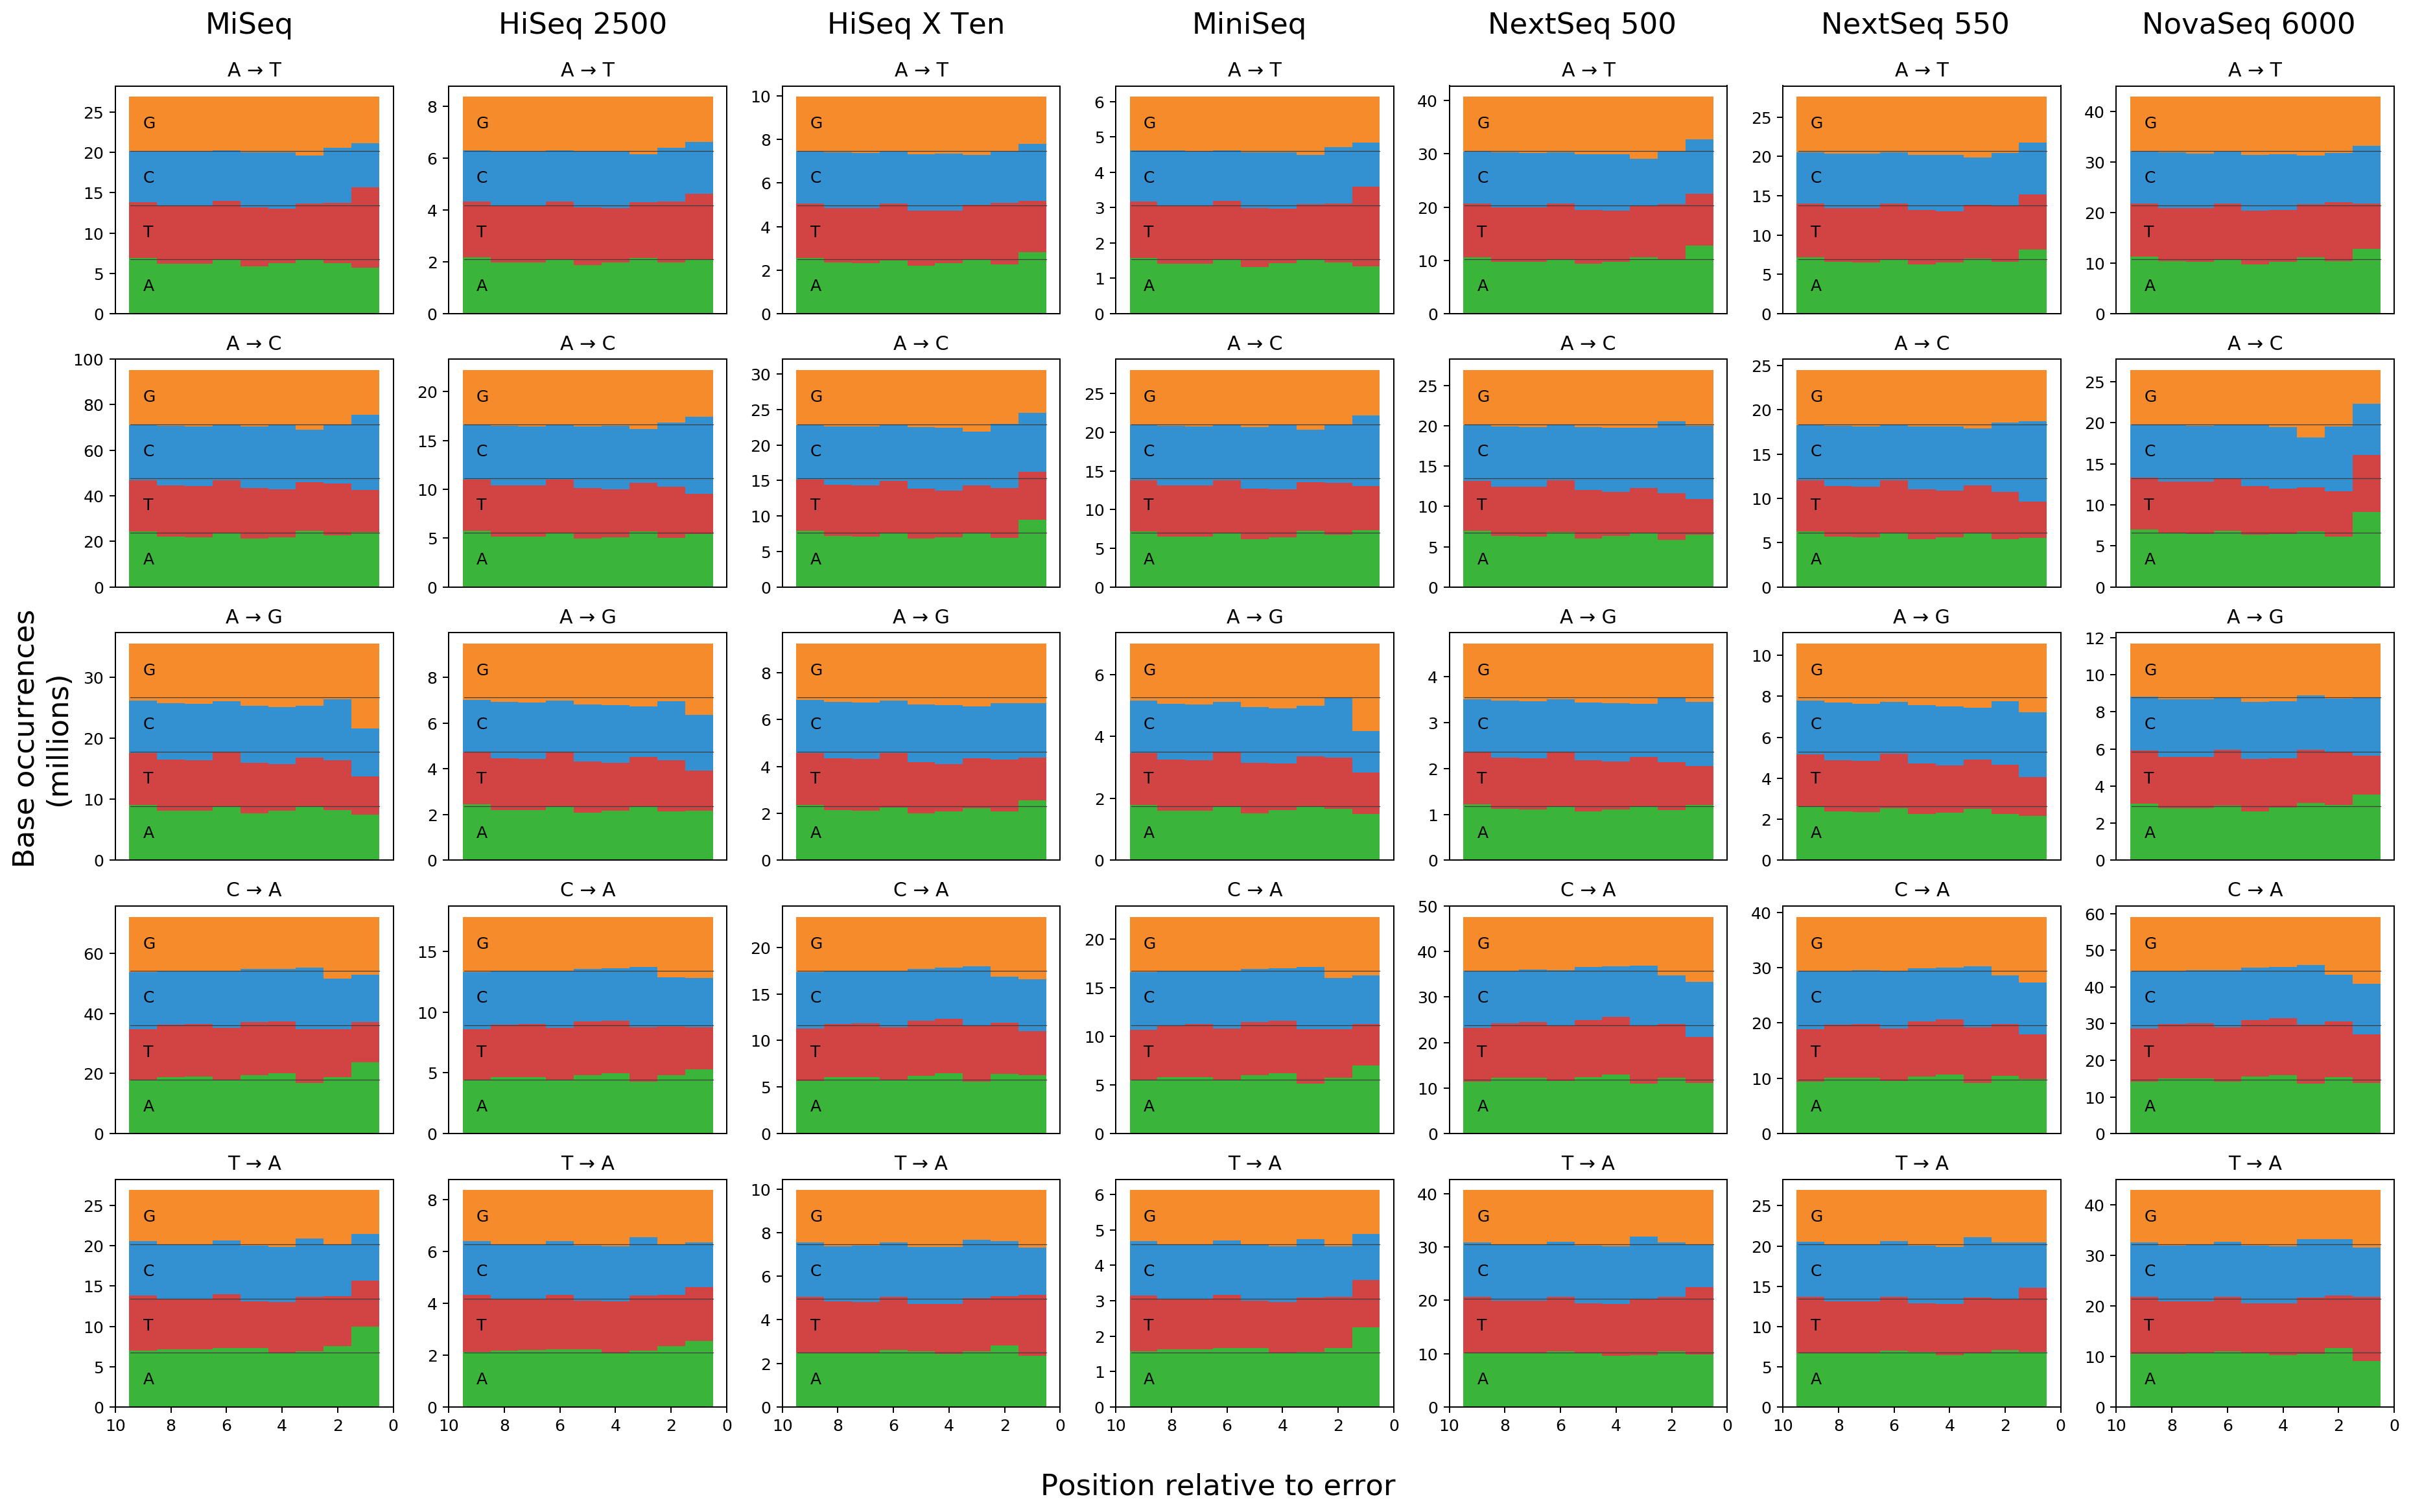

In [16]:
counts_multimultiplot(
  count_sets, folded=True, num_scale=10**6, aspect=1.2, substitutions=('AT','AC','AG','CA','TA')
)